In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
import ast
from collections import Counter
import numpy as np
from pandas_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn.datasets
from scipy import spatial
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.patches as patches
import mplcyberpunk
import seaborn as sns
from typing import List, Dict, Callable

%matplotlib inline
# plt.style.use('ggplot')
plt.style.use("cyberpunk")

In [3]:
from src.helpers import *

In [4]:
# Import Data
movies = pd.read_csv('cleaned_data/movies.csv')
users = pd.read_csv('cleaned_data/users.csv')
ratings = pd.read_csv('cleaned_data/ratings.csv')
nans = pd.read_csv('cleaned_data/nan_users.csv', )
ratings = ratings.rename(columns={'movie':'movie_id'})

In [5]:
users = users.drop(columns=['zipclean', 'occ'])
users

,user_id,gender,age,zipcode,occ_name
0,1,F,1,48067,K-12 student
1,2,M,56,70072,self-employed
2,3,M,25,55117,scientist
3,4,M,45,02460,executive/managerial
4,5,M,25,55455,writer
...,...,...,...,...,...
6035,6036,F,25,32603,scientist
6036,6037,F,45,76006,academic/educator
6037,6038,F,56,14706,academic/educator
6038,6039,F,45,01060,other


In [6]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  800000  ratings of  3883  movies.


In [7]:
ratings

,user,movie_id,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5
...,...,...,...
799995,1875,2940,5
799996,1875,589,4
799997,1875,110,4
799998,1875,2791,3


In [8]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movie_id', 'movie_title']], on='movie_id' )
user_movie_ratings = pd.pivot_table(ratings_title, index='user', columns= 'movie_title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (5399, 3662) 

Subset example:


movie_title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957)
user,,,,,,,,,,
636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


movie_title,American Beauty (1999),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode VI - Return of the Jedi (1983),Terminator 2: Judgment Day (1991),Saving Private Ryan (1998),Jurassic Park (1993),Back to the Future (1985),"Matrix, The (1999)",Men in Black (1997),...,Star Wars: Episode I - The Phantom Menace (1999),Being John Malkovich (1999),Groundhog Day (1993),"Godfather, The (1972)","Shawshank Redemption, The (1994)",Ghostbusters (1984),Forrest Gump (1994),Pulp Fiction (1994),"Terminator, The (1984)",Toy Story (1995)
3274,5.0,5.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,3.0,...,3.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0
648,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
751,5.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,...,4.0,3.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0
4458,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,...,1.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0
2623,5.0,5.0,5.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,...,3.0,3.0,3.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0


In [10]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='user', columns= 'movie_title', values='rating')
most_rated_movies = get_most_rated_movies(user_movie_ratings, user_movie_ratings.shape[0])

In [11]:
sparse_ratings = csr_matrix(most_rated_movies.apply(lambda x: pd.arrays.SparseArray(x)).sparse.to_coo())

In [12]:
# Predict 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

cluster # 17
# of users in cluster: 275. # of users in plot: 70


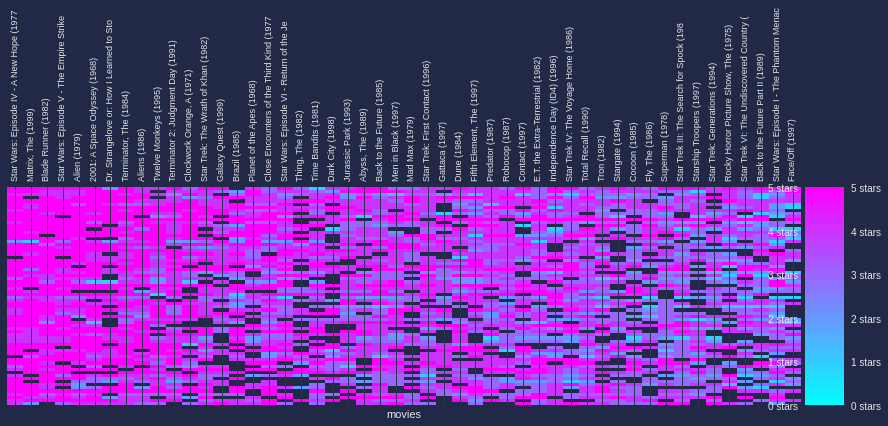

cluster # 13
# of users in cluster: 138. # of users in plot: 70


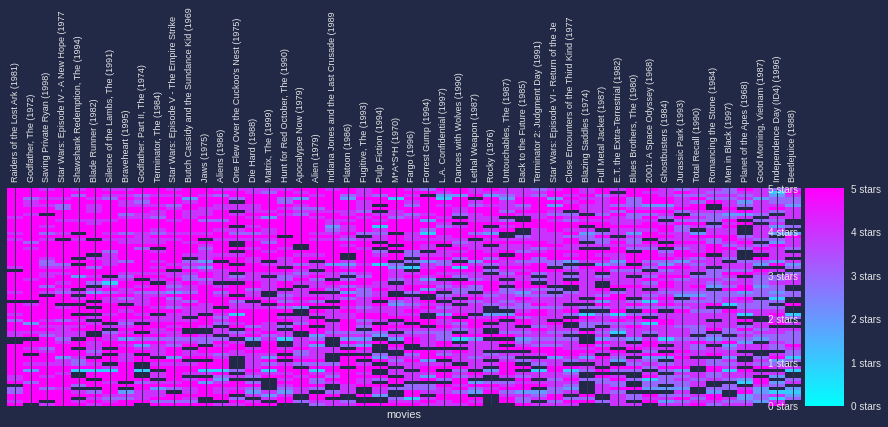

cluster # 2
# of users in cluster: 242. # of users in plot: 70


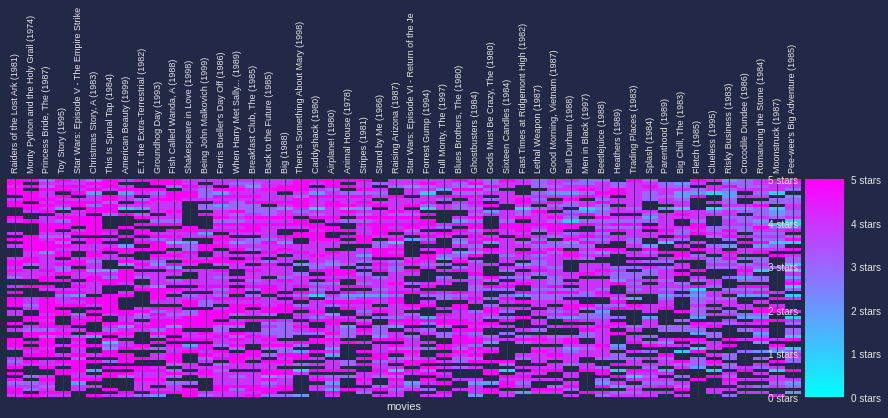

cluster # 18
# of users in cluster: 318. # of users in plot: 70


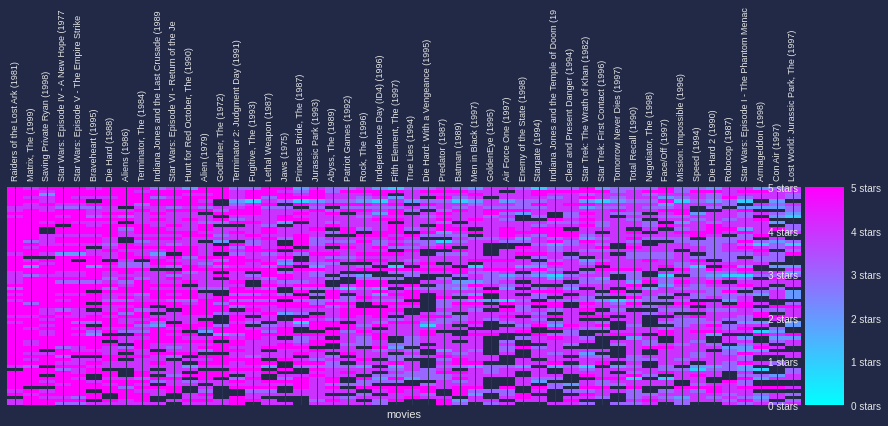

cluster # 16
# of users in cluster: 1969. # of users in plot: 70


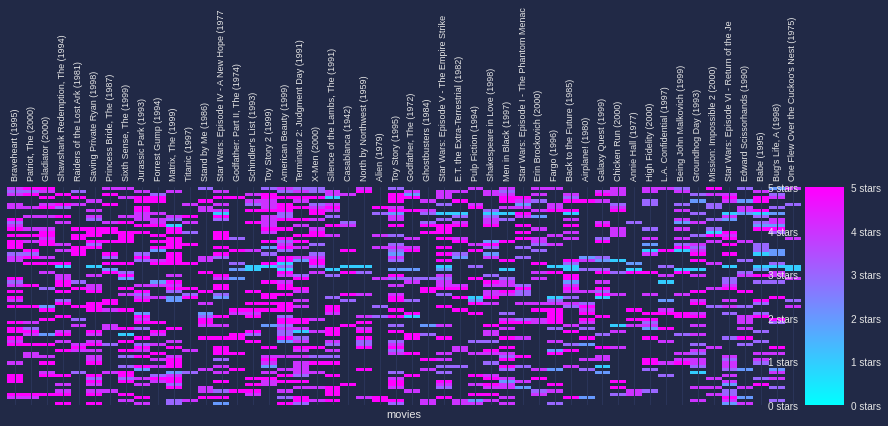

cluster # 5
# of users in cluster: 580. # of users in plot: 70


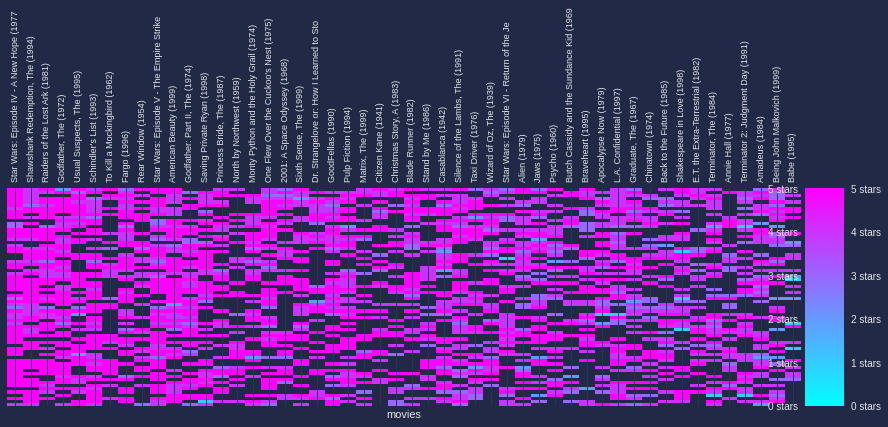

cluster # 1
# of users in cluster: 342. # of users in plot: 70


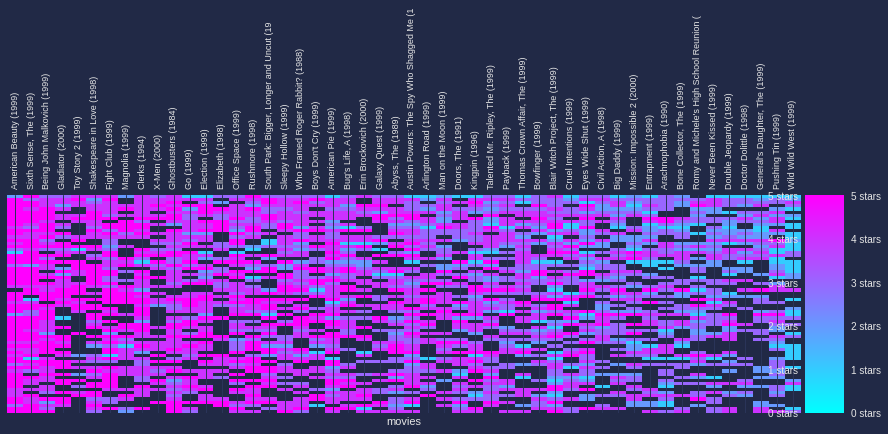

cluster # 4
# of users in cluster: 394. # of users in plot: 70


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


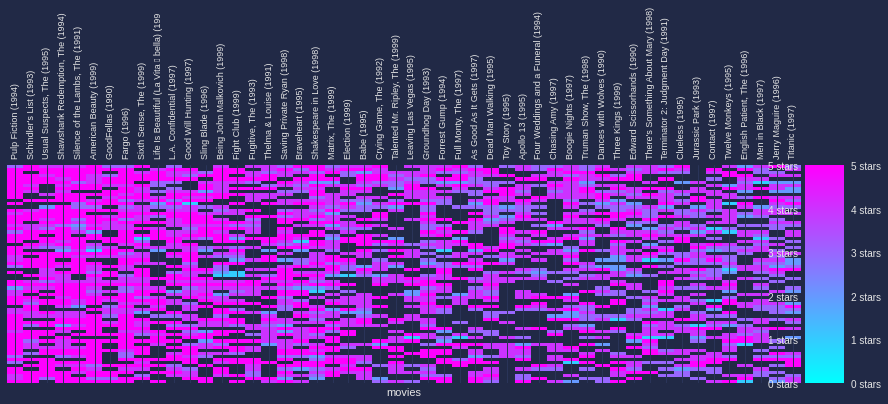

cluster # 14
# of users in cluster: 113. # of users in plot: 70


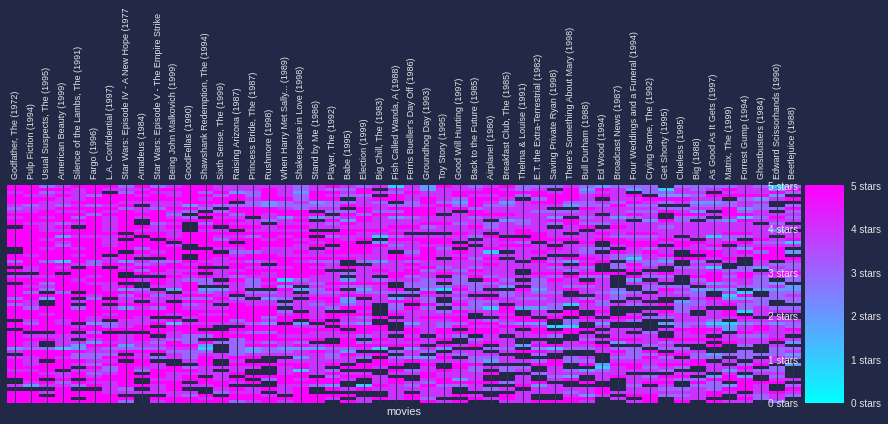

cluster # 12
# of users in cluster: 244. # of users in plot: 70


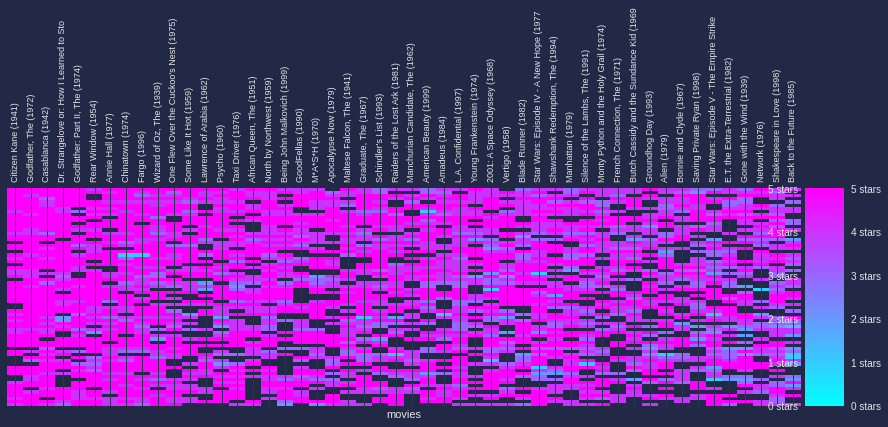

cluster # 3
# of users in cluster: 152. # of users in plot: 70


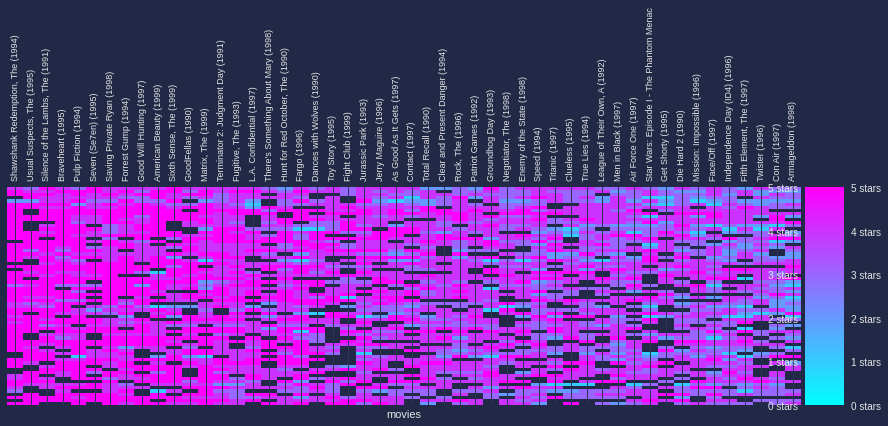

cluster # 0
# of users in cluster: 178. # of users in plot: 70


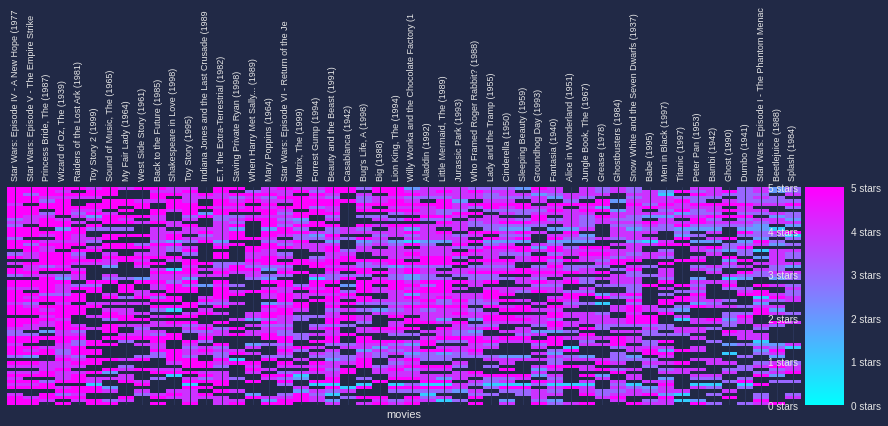

cluster # 7
# of users in cluster: 71. # of users in plot: 70


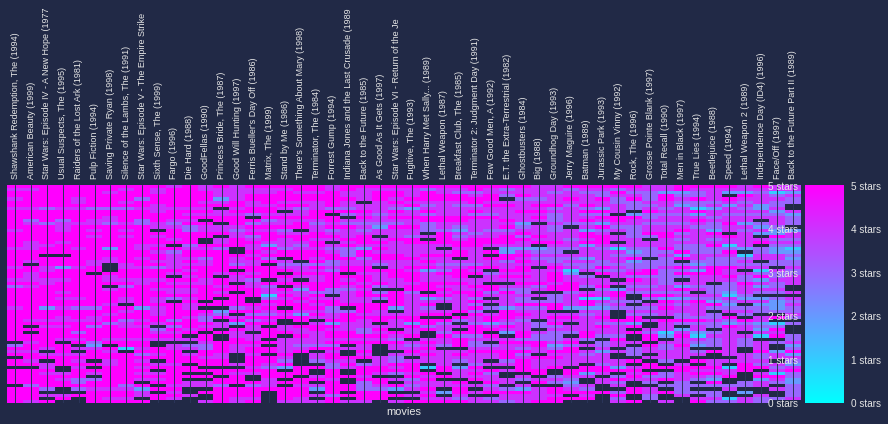

cluster # 11
# of users in cluster: 149. # of users in plot: 70


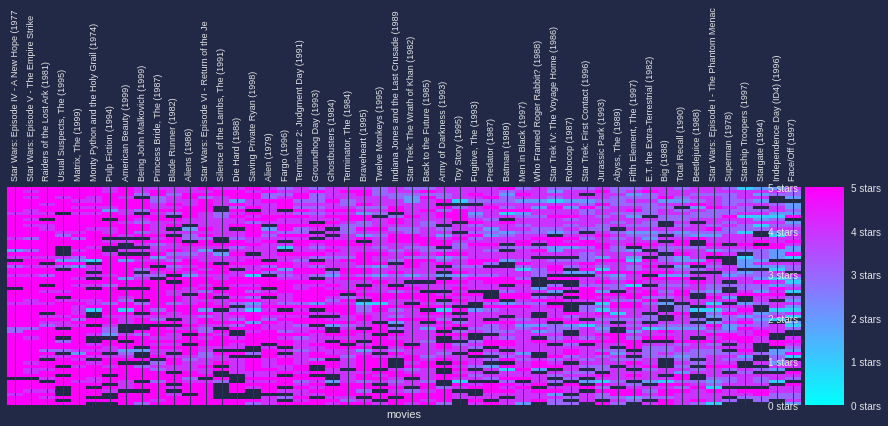

cluster # 8
# of users in cluster: 73. # of users in plot: 70


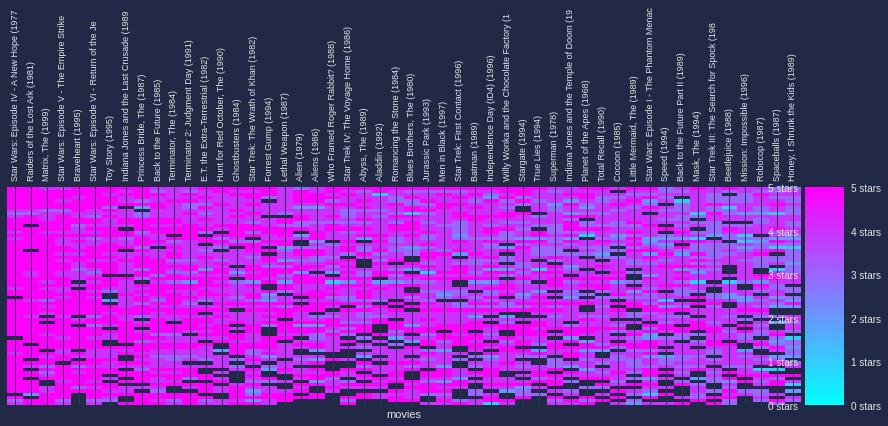

cluster # 6
# of users in cluster: 35. # of users in plot: 35


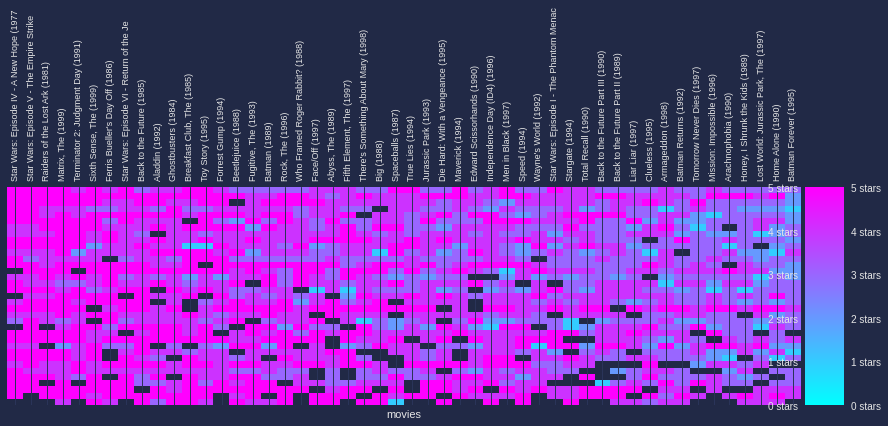

cluster # 9
# of users in cluster: 54. # of users in plot: 54


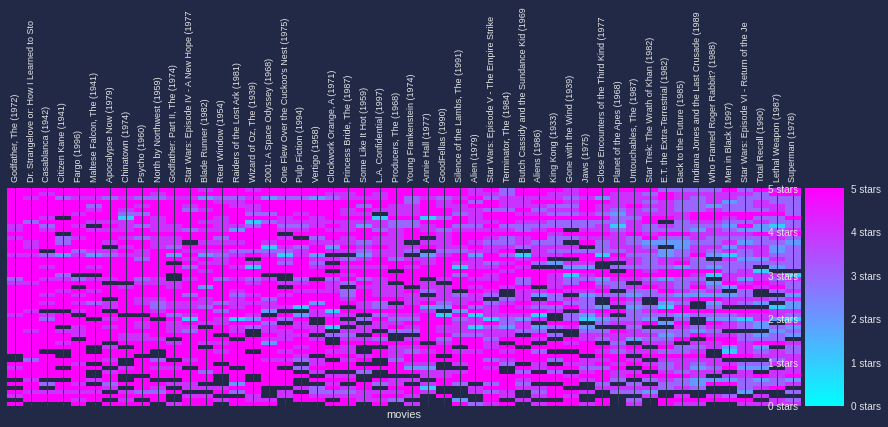

cluster # 19
# of users in cluster: 22. # of users in plot: 22


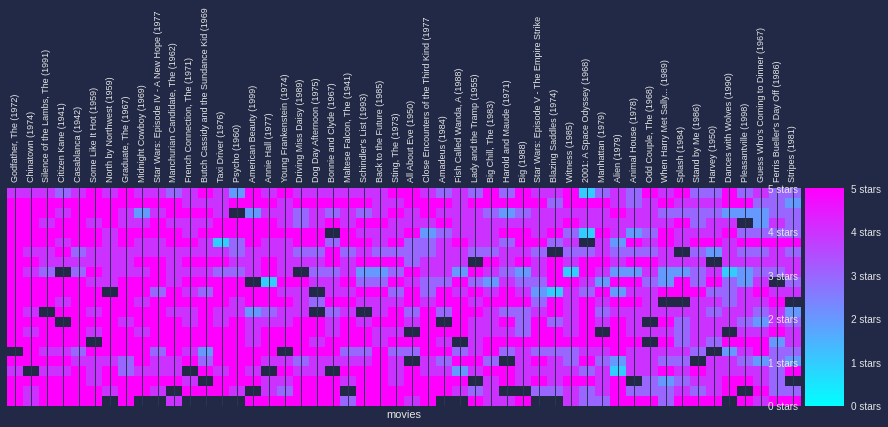

cluster # 10
# of users in cluster: 24. # of users in plot: 24


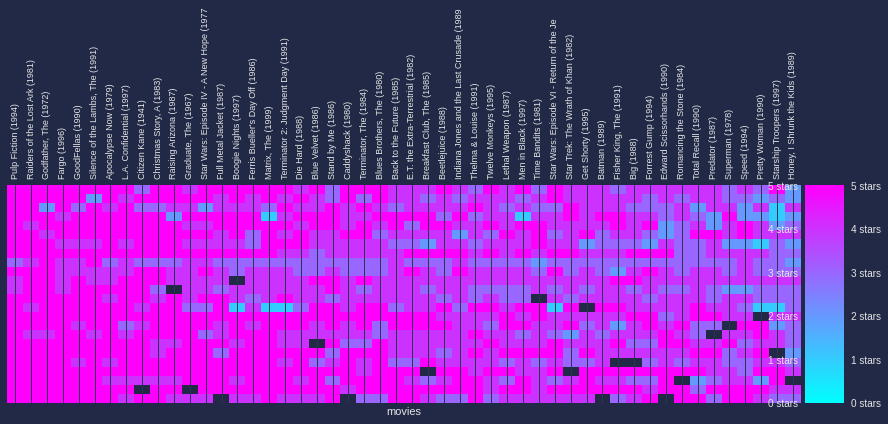

cluster # 15
# of users in cluster: 26. # of users in plot: 26


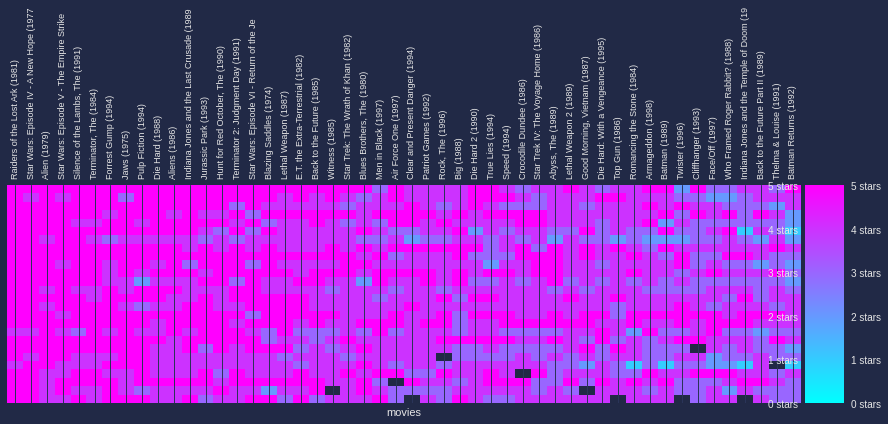

In [13]:
# Plot Heatmap
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

In [14]:
groups = clustered.groupby('group')

In [15]:
nans = nans.drop(columns = ['Unnamed: 0', 'prediction'])

In [16]:
def find_final_rating(user:int, movie:int) -> np.float:
    group_no = int(clustered.iloc[user]['group'])
    # Filter Num Users and Max Amount of Movies
    n_users = 75
    n_movies = 300
    cluster = clustered[clustered.group == group_no].drop(['index', 'group'], axis=1)
    # Get Movie Name
    mov = movies[movies['movie_id'] == movie]['movie_title'].tolist()[0]
    return (cluster[mov].mean())
    


In [ ]:
# find_final_rating(1875, 3793)
fake_test = pd.read_csv('data/fake_testing.csv')


user_arr = fake_test['user'].tolist()
movie_arr = fake_test['movie'].tolist()

predictions = []

for user, movie in zip(user_arr, movie_arr):
    try:
        predictions.append(find_final_rating(user, movie))
    except:
        predictions.append(np.nan)

In [ ]:
fake_test['predicitons'] = predictions

In [ ]:
fake_test